<a href="https://colab.research.google.com/github/rsomou/CS-Projects/blob/main/files/cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EE 508 HW 2: Convolution Neural Network

Your task in this Colab notebook is to fill out the sections that are specified by **TODO** (please search the keyword `TODO` to make sure you do not miss any).

Prerequisites: set the runtime type to GPU. (Runtime -> Change Runtime Type)

In [54]:
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader

Verify that GPU is availble to use.

In [55]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print("Device", device)

Device cuda


## Convolution

Definition:
Convolution is a mathematical operation where a filter (or kernel) is applied over an input (e.g., image) to produce a modified output known as a feature map.

Key Components:
- Kernel/Filter: A small matrix that slides over the input. It captures patterns or features from the input.
  
- Stride: The number of pixels the filter moves at each step.
  
- Padding: Zeros added around the input's border, often used to control the output's spatial dimensions.

Operation:
The filter starts at the top-left corner of the image. For each position, values under the filter are multiplied with its corresponding filter values, then summed to produce a single pixel in the output. This process is repeated across the entire input.

## Create a sample image

Create a 3D  `image` of shape `(1,10,10)` as a numpy-array. The signal values are 1 (white) in the `(4,4)`-center region and 0 (black) elsewhere.

Plot the image as a grid with black or white colors and write the 0 or 1 value on each cell.

In [56]:
# Create a 1x10x10 image filled with zeros
image = np.zeros((1, 10, 10), dtype=np.float32)

# Set a 4x4 sub-matrix (starting from index 3 to 7 both for rows and columns) to be filled with ones
image[0, 3:7, 3:7] = 1

# Print the formatted matrix
print(image)
print(image.shape)

[[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
  [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
  [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
  [0. 0. 0. 1. 1. 1. 1. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
(1, 10, 10)


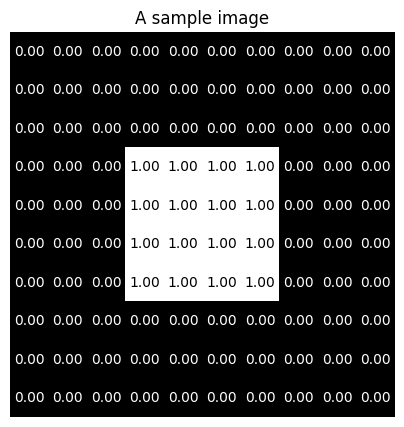

In [57]:
def plot_image_with_values(image, title):
    """
    Plots a 3D image with numeric values overlaid on each cell.

    Parameters:
    - image (3D numpy array): The image to be plotted.
    - title (str): The title of the plot.
    """
    plt.figure(figsize=(5,5))

    # Plot the image
    plt.imshow(image[0], cmap='gray')

    # Looping through all cells to overlay the numeric values
    for i in range(image.shape[1]):
        for j in range(image.shape[2]):
            pixel_value = image[0, i, j]
            text_color = 'white' if pixel_value < 0.5 else 'black'  # Setting text color based on pixel value
            plt.text(j, i, f'{pixel_value:.2f}', ha='center', va='center', color=text_color)

    plt.title(title)
    plt.axis('off')
    plt.show()


plot_image_with_values(image, 'A sample image')

## Average Filter

### **TODO 1**:
Implement a function that applies a 3x3 average filter to an input image using PyTorch's [conv2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) function. The filter should have all values set to 1/9, ensuring the sum is 1, and use a padding of 1 to keep the output image dimensions the same as the input.

Note that the input and output of the `average_filter` function are numpy array type, so you need to convert numpy array to pytorch tensor, process the tensor, and convert pytorch tensor back to numpy array.

In [58]:
# Skeleton for TODO 1
def average_filter(image):
    """
    Apply a 3x3 average filter to the input image using PyTorch and return the filtered image.

    Args:
    - image: A 3D numpy array representing the input image.

    Returns:
    - filtered_img: A 3D numpy array representing the image after applying the filter.
    """

    # 1. Convert image to a PyTorch tensor
    # we need (batch_size, channels, height, width).
    image_t = torch.tensor(image, dtype=torch.float32).unsqueeze(0)

    # 2. Define a 3x3 average filter with all values set to 1/9
    kernel = torch.ones((1, 1, 3, 3), dtype=torch.float32) / 9.0

    # 3. Apply conv2d with padding=1
    filtered_img_t = F.conv2d(image_t, kernel, padding=1)

    # 4. Convert back to numpy
    # remove the batch dimension
    filtered_img = filtered_img_t.squeeze(0).numpy()

    return filtered_img

Plot the image as a grid with black or white colors and write the 0 or 1 value on each cell.

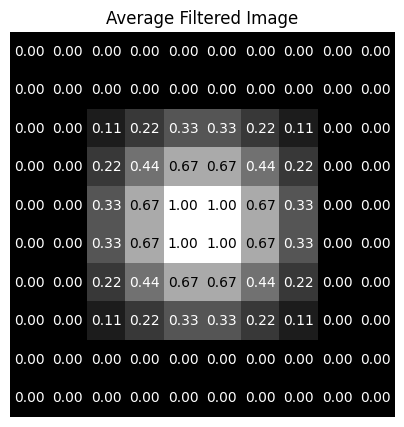

In [59]:
filtered_img = average_filter(image)
plot_image_with_values(filtered_img, 'Average Filtered Image')

## Edge Detection

In image processing, edge detection refers to the process of identifying abrupt changes or discontinuities in an image. These abrupt changes often correspond to object boundaries, textures, or other significant features.

The concept of **central differences** can be applied to images to detect edges by estimating the gradient magnitude at each pixel. In the context of images, the derivative approximations can highlight the areas of rapid intensity change, which are often the edges.

Using the concept of central differences, one possible filter for vertical edge detection is:
\begin{bmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1 \\
\end{bmatrix}

### **TODO 2**:
Implement a function that applies a 3x3 vertical edge detection filter to an input image using PyTorch's [conv2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) function.

In [60]:
# Skeleton for TODO 2
def vertical_edge_detection(image):
    """
    Apply a 3x3 vertical edge detection filter to the input image using PyTorch and return the filtered image.

    Args:
    - image: A 3D numpy array representing the input image.

    Returns:
    - filtered_img: A 3D numpy array representing the image after applying the filter.
    """

    # 1. Convert image to tensor
    image_t = torch.tensor(image, dtype=torch.float32).unsqueeze(0)

    # 2. Define the vertical edge filter
    kernel = torch.zeros((1,1,3,3),dtype=torch.float32)
    kernel[0][0][:,0] = -1
    kernel[0][0][:,2] = 1

    # 3. Apply conv2d with padding=1
    filtered_img_t = F.conv2d(image_t, kernel, padding=1)

    # 4. Convert back to numpy
    filtered_img = filtered_img_t.squeeze(0).numpy()

    return filtered_img

## Applying Filters on an Actual Image

In this section we apply several filters on an actual image.

Use `PIL` library to read a image from online resource called `sheep.jpg` as a numpy array. Convert that image to grayscale so that it only has a single channel and plot the image.

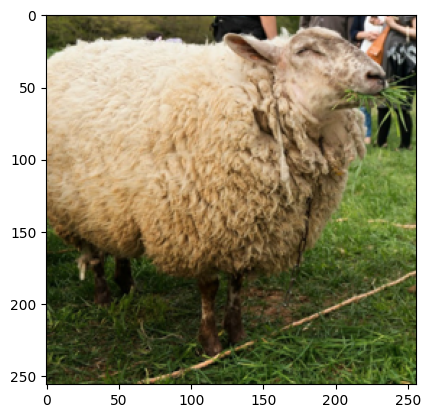

In [61]:
from PIL import Image
import urllib.request

image = Image.open(urllib.request.urlopen('https://chokkan.github.io/deeplearning/assets/images/sheep.jpg'))
image = image.resize((256, 256))  # resize image.
plt.imshow(image)

image = image.convert('L')  # convert to grey scale
image = np.array(image, dtype=np.float32) / 255  # normalize image to range [0, 1]
image = np.expand_dims(image, axis=0)  # expand to 3 dimensional

Create a function that can plot both the original image and its modified version side by side.

In [62]:
def plot_original_and_modified(original_img, modified_img):
    """
    Plot the original image and its modified version side by side.

    Args:
    - original_img: A 3D numpy array representing the original image.

    - modified_img: A 3D numpy array representing the the modified version of the original image.
    """

    # Ensure that the input arrays are in the range [0, 1]
    original_img = np.clip(original_img, 0, 1)[0]
    modified_img = np.clip(modified_img, 0, 1)[0]

    plt.figure(num=None, figsize=(12,12), dpi=80, facecolor='w', edgecolor='k')

    # Plot the original image
    plt.subplot(1,2,1)
    plt.imshow(original_img, cmap='Greys_r')
    plt.title("Original Image")

    # Plot the modified image
    plt.subplot(1,2,2)
    plt.imshow(modified_img, cmap='Greys_r')
    plt.title("Modified Image")

    plt.show()

Apply the `vertical_edge_detection` funtion implemented above to the image.

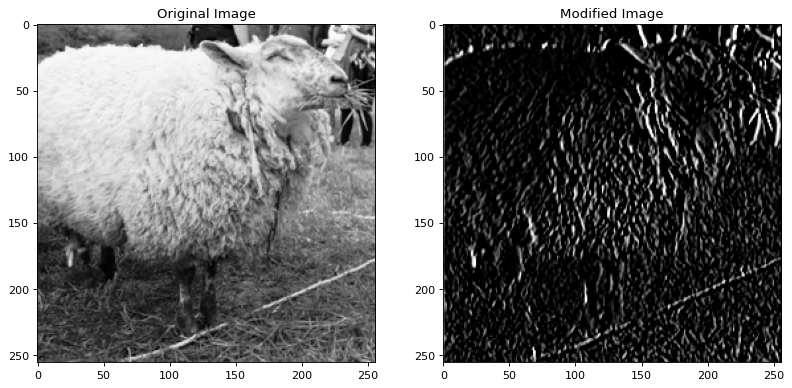

In [63]:
filtered_img = vertical_edge_detection(image)
plot_original_and_modified(image, filtered_img)

### **TODO 3:**
Implement a function that applies a 3x3 **horizontal** edge detection filter to an input image using PyTorch's [conv2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) function. What should the filter be in this case?

In [64]:
# Skeleton for TODO 3
def horizontal_edge_detection(image):
    """
    Apply a 3x3 horizontal edge detection filter to the input image using PyTorch and return the filtered image.

    Args:
    - image: A 3D numpy array representing the input image.

    Returns:
    - filtered_img: A 3D numpy array representing the image after applying the filter.
    """

    # 1. Convert image to tensor
    image_t = torch.tensor(image, dtype=torch.float32).unsqueeze(0)

    # 2. Define the horizontal edge filter
    kernel = torch.zeros((1,1,3,3),dtype=torch.float32)
    kernel[0][0][0,:] = -1
    kernel[0][0][2,:] = 1

    # 3. Apply conv2d with padding=1
    filtered_img_t = F.conv2d(image_t, kernel, padding=1)

    # 4. Convert back to numpy
    filtered_img = filtered_img_t.squeeze(0).numpy()
    filtered_img = None

    return filtered_img

### **TODO 4:**
Lapalacian filters can increase the regions of the image with rapid intensity. It is very helpful in hiding the fine details of images. Any features with a sharp discontunioty will be enhanced.

One of the Laplacian filter is

\begin{bmatrix}
 0 & -1 &  0 \\
-1 &  5 & -1 \\
 0 & -1 &  0 \\
\end{bmatrix}


Implement a function that applies a 3x3 laplacian filter to an input image using PyTorch's [conv2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) function.

In [65]:
# Skeleton for TODO 4
def laplacian_filter(image):
    """
    Apply a 3x3 laplacian filter to the input image using PyTorch and return the filtered image.

    Args:
    - image: A 3D numpy array representing the input image.

    Returns:
    - filtered_img: A 3D numpy array representing the image after applying the filter.
    """

    # 1. Convert image to tensor
    image_t = torch.tensor(image, dtype=torch.float32).unsqueeze(0)


    # 2. Define laplacian filter
    laplacian_filter = torch.tensor(
        [[0,-1,0],
         [-1,5,-1],
         [0,-1,0]], dtype=torch.float32
    ).reshape((1,1,3,3))

    # 3. Apply conv2d with padding=1
    filtered_img_t = F.conv2d(image_t, laplacian_filter, padding=1)

    # 4. Convert back to numpy
    filtered_img = filtered_img_t.squeeze(0).numpy

    return filtered_img

### **TODO 5:**

The Gaussian filter is commonly used for blurring image. Its values are determined by the Gaussian function, resulting in a weighted average that emphasizes the central pixel and decreases the influence of neighboring pixels as the distance increases.

The specific weights for the 3x3 Gaussian filter are arranged as follows, ensuring that the sum of all weights is equal to 1, which preserves the overall brightness of the image:

\begin{bmatrix}
1/16 & 2/16 & 1/16 \\
2/16 & 4/16 & 2/16 \\
1/16 & 2/16 & 1/16 \\
\end{bmatrix}

This arrangement of weights creates a bell-shaped curve, centralizing the focus on the middle pixel while progressively giving less importance to pixels further away.

Implement a function that applies a 3x3 gaussian filter to an input image using PyTorch's [conv2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html) function.

In [66]:
# Skeleton for TODO 5
def gaussian_filter(image):
    """
    Apply a 3x3 gaussian filter to the input image using PyTorch and return the filtered image.

    Args:
    - image: A 3D numpy array representing the input image.

    Returns:
    - filtered_img: A 3D numpy array representing the image after applying the filter.
    """

    # 1. Convert image to tensor
    image_t = torch.tensor(image, dtype=torch.float32).unsqueeze(0)


    # 2. Define laplacian filter
    gaussian_filter = torch.tensor(
        [[1/16,2/16,1/16],
         [2/16,4/16,2/16],
         [1/16,2/16,1/16]], dtype=torch.float32
    ).reshape((1,1,3,3))

    # 3. Apply conv2d with padding=1
    filtered_img_t = F.conv2d(image_t, gaussian_filter, padding=1)

    # 4. Convert back to numpy
    filtered_img = filtered_img_t.squeeze(0).numpy

    return filtered_img

## Pooling

Pooling is an operation frequently used in the context of Convolutional Neural Networks (CNNs) for image processing. The main idea behind pooling is to reduce the spatial size of the representation, thereby reducing the number of parameters and computational complexity in the network. This helps in making the network less prone to overfitting and also reduces computation time.

There are several types of pooling operations, with the most common ones being:

**Max Pooling**: In this method, for each segment of the input, the maximum value is selected. For instance, if we consider a 2x2 pooling window (often called a "kernel" in this context) and slide it over an image tensor, the largest value within each 2x2 window will be selected for the pooled output.

**Average Pooling**: Instead of taking the maximum value in each window, average pooling takes the average value. So for a 2x2 window, it would take the average of all 4 values in that window.

**Min Pooling**: This operation selects the minimum value from each window, though it's less commonly used than max or average pooling.

**Global Pooling**: Instead of using a fixed size window, global pooling operates over the entire height and width of the feature map, effectively transforming the spatial dimensions of the feature map to 1x1 (retaining the depth/channels).

The main benefits of pooling include:

- **Dimensionality Reduction**: It reduces the spatial dimensions of the feature maps, which in turn reduces the number of parameters in subsequent layers, leading to faster computations.
- **Invariance to Small Translations**: Small translations in the input image might not lead to significant changes in the pooled feature map. This can be particularly useful when the exact location of features is less relevant than their presence.
- **Prevents Overfitting**: By reducing the spatial resolution and thus the total number of parameters, pooling can help prevent overfitting.


### **TODO 6:**
Implement a function that applies a 5x5 max pooling filter with stride 5 to an input image using PyTorch's [max_pool2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.max_pool2d.html) function.

In [67]:
# Skeleton for TODO 6
def max_pooling(image):
    """
    Apply a 5x5 max pooling to the input image using PyTorch and return the filtered image.

    Args:
    - image: A 3D numpy array representing the input image.

    Returns:
    - filtered_img: A 3D numpy array representing the image after applying the filter.
    """

    # 1. Convert image to tensor
    image_t = torch.from_numpy(image).float().unsqueeze(0)

    # 2. Apply max_pool2d with kernel_size=5 and stride=5
    filtered_img_t = F.max_pool2d(image_t, kernel_size=5, stride=5)

    # 3. Convert back to numpy
    filtered_img = filtered_img_t.squeeze(0).numpy()

    return filtered_img

### **TODO 7:**
Implement a function that applies a 5x5 average pooling filter with stride 5 to an input image using PyTorch's [avg_pool2d](https://pytorch.org/docs/stable/generated/torch.nn.functional.avg_pool2d.html) function.

In [68]:
# Skeleton for TODO 7
def average_pooling(image):
    """
    Apply a 5x5 average pooling to the input image using PyTorch and return the filtered image.

    Args:
    - image: A 3D numpy array representing the input image.

    Returns:
    - filtered_img: A 3D numpy array representing the image after applying the filter.
    """

    # 1. Convert image to tensor
    image_t = torch.from_numpy(image).float().unsqueeze(0)

    # 2. Apply avg_pool2d with kernel_size=5 and stride=5
    filtered_img_t = F.avg_pool2d(image_t, kernel_size=5, stride=5)

    # 3. Convert back to numpy
    filtered_img = filtered_img_t.squeeze(0).numpy()

    return filtered_img

## Convolutional Neural Networks

The construction of neural networks is facilitated through the utilization of the ``torch.nn`` package within the PyTorch framework.

A standard process for training a neural network involves the following steps:

1. **Neural Network Definition:** The first step entails defining the architecture of the neural network, which encompasses the design of its interconnected layers and the inclusion of learnable parameters, often referred to as weights.

2. **Iterative Data Processing:** Next, the training procedure involves iterating through a dataset containing input samples. Each input is fed into the neural network for processing.

3. **Forward Propagation:** During this phase, the input data is passed through the neural network's layers, activating its neurons through weighted connections and producing an output prediction.

4. **Loss Computation:** The output generated by the network is then compared to the actual desired output, leading to the computation of a loss value. This loss signifies the discrepancy between the predicted outcome and the true value.

5. **Backpropagation:** After calculating the loss, the gradients of the loss with respect to the network's parameters are computed through a process called backpropagation. This entails tracing how changes in the parameters affect the loss.

6. **Gradient Update:** The gradients computed during backpropagation are used to adjust the network's weights. A common method involves updating the weights by subtracting a scaled gradient value from the current weights. The scale factor, known as the learning rate, determines the step size of the update. This update rule can be expressed as: ``weight = weight - learning_rate * gradient``.

Throughout this iterative process, the neural network's parameters are fine-tuned to minimize the loss and enhance its predictive accuracy. This sequence of steps forms the backbone of training neural networks, enabling them to learn and improve their performance over time.

In this assignment we will create a simple CNN.


To begin this section, we will load the CIFAR10 dataset and train a simple convolutional neural network (CNN) to classify the images.

The CIFAR10 dataset has the classes:

* `airplane`
* `automobile`
* `bird`
* `cat`
* `deer`
* `dog`
* `frog`
* `horse`
* `ship`
* `truck`

The images in CIFAR-10 are of size:

* `3x32x32`

i.e. 3-channel color images of `32x32` pixels in size.

To load the data, we use a package called
``torchvision``, that has data loaders for common datasets such as
ImageNet, CIFAR10, MNIST, etc. and data transformers for images, namely,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.


In the following code, we perform the following:

* Define a batch size for processing multiple images in each iteration.
* Create a series of transformations to be applied to the images in the dataset: converting images to tensors and normalizing the pixel values.
* Load the CIFAR10 **training** and **test** datasets, specifying the root directory, training mode, and transformations.
* Construct a DataLoader for the **training** and **test** datasets with batch processing, shuffling, and parallel data loading.

In [69]:
# Set the batch size for data processing
batch_size = 4

# Define the mean values and standard deviation values for normalization
mean_values = (0.5, 0.5, 0.5)  # Mean values for red, green, and blue channels
std_values = (0.5, 0.5, 0.5)   # Standard deviation values for red, green, and blue channels

# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),                  # Convert images to tensors
    transforms.Normalize(mean_values, std_values)  # Normalize tensor values
])

# Load the CIFAR10 training dataset and apply the defined transformations
trainset = torchvision.datasets.CIFAR10(root="./", train=True,
                                        download=True, transform=transform)

# Create a DataLoader to efficiently load and process training data in batches
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

# Load the CIFAR10 test dataset and apply the same transformations as for training
testset = torchvision.datasets.CIFAR10(root="./", train=False,
                                       download=True, transform=transform)

# Create a DataLoader for test data
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Let's view some of the images.

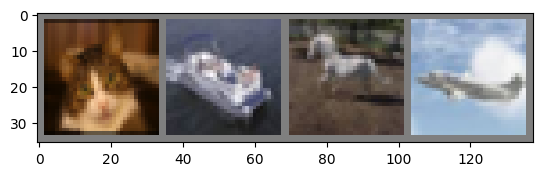

Labels: cat   ship  horse plane


In [70]:
# Define a function to display images
def imshow(img):
    # Unnormalize the image
    # The normalization was done using this formula:
    # img_norm = (img - mean) / std
    # So we unnormalize as follows:
    img = img * 0.5 + 0.5

    npimg = img.numpy()

    #The image array is typically stored in the order [height, width, channels],
    #but the plt.imshow function expects the image array to be stored in the
    #order [channels, width, height].
    #The np.transpose function transposes the image array,
    #so that it is stored in the correct order.
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

    # Display the image
    plt.show()

# Get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show the images using the imshow function
imshow(torchvision.utils.make_grid(images))

# Print labels
print('Labels:', ' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

### **TODO 8:**

Implement a simple CNN model with the architecure defined in the comments to classify images from the CIFAR-10 dataset. The CIFAR-10 dataset comprises 3x32x32 pixel RGB color images with 10 distinct categories.

In [71]:
# Skeleton for TODO 8
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # conv1: 3 input channels, 6 output channels, kernel size 5x5
        self.conv1 = nn.Conv2d(3, 6, 5)

        # maxpool: kernel size 2x2 and stride 2 (This is an operation, not a layer to define here)

        # conv2: 6 input channels, 16 output channels, kernel size 5x5
        self.conv2 = nn.Conv2d(6, 16, 5)

        # fc1: 16*5*5 input features, 120 output features
        self.fc1 = nn.Linear(16 * 5 * 5, 120)

        # fc2: 120 input features, 84 output features
        self.fc2 = nn.Linear(120, 84)

        # fc3: 84 input features, 10 output features
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Apply first convolutional layer, followed by ReLU activation and max pooling
        x = F.max_pool2d(F.relu(self.conv1(x)), 2) # Kernel size 2x2, stride 2 (default for F.max_pool2d)

        # Apply second convolutional layer, followed by ReLU activation and max pooling
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        # Reshape tensor for fully connected layers
        x = x.view(-1, 16 * 5 * 5)

        # Apply first fully connected layer, followed by ReLU activation
        x = F.relu(self.fc1(x))

        # Apply second fully connected layer, followed by ReLU activation
        x = F.relu(self.fc2(x))

        # Apply third fully connected layer (output layer)
        x = self.fc3(x)

        return x

# Create an instance of the neural network and move it to the specified device
net = Net().to(device)

### **TODO 9:**

Implement the training loop for your CNN model. The loop should feed input data to the model, compute the loss using the correct labels, and update the model weights using an optimization algorithm.

In [72]:
# Skeleton for TODO 9
def train(model: nn.Module, dataloader: DataLoader, epoch_num: int):
    # Define the loss criterion and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    # Loop over the dataset for multiple epochs
    for epoch in range(epoch_num):
        running_loss = 0.0

        # Iterate over mini-batches of data
        for i, (inputs, labels) in enumerate(dataloader, 0):
            # Move inputs and labels to device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the gradients in the optimizer
            optimizer.zero_grad()

            # Forward pass + backward pass + optimization
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    print('Finished Training')

Train this CNN on the training dataset with 2 epochs (this may take a few moments).

In [73]:
train(net, trainloader, 2)

[1,  2000] loss: 2.185
[1,  4000] loss: 1.850
[1,  6000] loss: 1.663
[1,  8000] loss: 1.569
[1, 10000] loss: 1.515
[1, 12000] loss: 1.464
[2,  2000] loss: 1.396
[2,  4000] loss: 1.377
[2,  6000] loss: 1.342
[2,  8000] loss: 1.331
[2, 10000] loss: 1.298
[2, 12000] loss: 1.292
Finished Training


Having successfully trained our CNN, it's now time to evaluate its generalization performance on new, unseen data. We'll do this by selecting a few sample images from our test dataset.

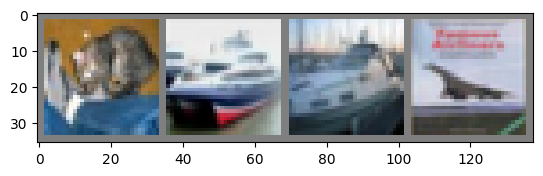

GroundTruth:  cat   ship  ship  plane
Predicted:  cat   ship  ship  plane


In [74]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

net = net.to(device)
net.eval()
images = images.to(device)
with torch.no_grad():
    outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j].item()]:5s}'
                              for j in range(4)))

### **TODO 10:**

In the following code cell, implement a function that measures classification accuracy of the provided neural network model using the entire test dataset. This function should calculate and return the percentage of correctly predicted samples in the test dataset.

In [75]:
# Skeleton for TODO 10
def calculate_accuracy(model: nn.Module, dataloader: DataLoader) -> float:
    """
    Evaluate the classification accuracy of a neural network model on a given test dataset.
    """

    correct_predictions = 0
    total_samples = 0

    # Disable gradient calculations and evaluate over the test dataset
    model.eval() # Set the model to evaluation mode
    with torch.no_grad(): # Disable gradient computation
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    accuracy = 100 * correct_predictions / total_samples
    return accuracy

# Evaluating the model's accuracy on the test dataset
accuracy_score = calculate_accuracy(net, testloader)
print(f'Accuracy of the network on the test images: {accuracy_score:.2f}%')

Accuracy of the network on the test images: 51.32%


### **TODO 11:**

Apply filter decomposition to the first convolutional layer of a neural network in PyTorch. The original layer is defined as a 5x5 convolution, and we will decompose it into two layers with 3x3 and 3x3 filters. The intermediate output channel is 3. Train the model and evaluate the accuracy.

In [76]:
# Skeleton for TODO 11
net = Net().to(device)

# replace the first conv by two conv layers
net.conv1 = nn.Sequential(
    nn.Conv2d(3, 3, 3),
    nn.Conv2d(3, 6, 3)
)

net = net.to(device)

# train the model and evaluate the accuracy
train(net, trainloader, 2)
accuracy_score = calculate_accuracy(net, testloader)
print(f'Accuracy of the network on the test images: {accuracy_score:.2f}%')

[1,  2000] loss: 2.190
[1,  4000] loss: 1.981
[1,  6000] loss: 1.823
[1,  8000] loss: 1.676
[1, 10000] loss: 1.545
[1, 12000] loss: 1.445
[2,  2000] loss: 1.382
[2,  4000] loss: 1.365
[2,  6000] loss: 1.310
[2,  8000] loss: 1.311
[2, 10000] loss: 1.280
[2, 12000] loss: 1.279
Finished Training
Accuracy of the network on the test images: 57.90%


### **TODO 12:**

Apply filter decomposition to the first convolutional layer of a neural network in PyTorch. The original layer is defined as a 5x5 convolution, and we will decompose it into two layers with 5x1 and 1x5 filters. The intermediate output channel is 3. Train the model and evaluate the accuracy.

In [77]:
# Skeleton for TODO 12
net = Net().to(device)
# replace the first conv by two conv layers
net.conv1 = nn.Sequential(
    # 3 input channels, 3 output channels, kernel size 5x1
    nn.Conv2d(3, 3, kernel_size=(5, 1)),
    # 3 input channels, 6 output channels, kernel size 1x5
    nn.Conv2d(3, 6, kernel_size=(1, 5)),
)
net = net.to(device)
# train the model and evaluate the accuracy
train(net, trainloader, 2)
accuracy_score = calculate_accuracy(net, testloader)
print(f'Accuracy of the network on the test images: {accuracy_score:.2f}%')

[1,  2000] loss: 2.250
[1,  4000] loss: 2.025
[1,  6000] loss: 1.880
[1,  8000] loss: 1.733
[1, 10000] loss: 1.672
[1, 12000] loss: 1.571
[2,  2000] loss: 1.503
[2,  4000] loss: 1.444
[2,  6000] loss: 1.404
[2,  8000] loss: 1.378
[2, 10000] loss: 1.349
[2, 12000] loss: 1.308
Finished Training
Accuracy of the network on the test images: 50.40%


### **TODO 13:**
1. In the CNN model we have created, how many layers have trainable weights? Please list all the dimensions of each layer's weights.

2. For each of the layers with traiable weights, please list their input and output dimension.

3. The outputs of a neural network before the activation function is applied are named as "logits". For multi-class clasification, we know that we need to apply softmax activation function to logits and then compute cross-entropy loss on it. However, in our `Net` class where we define the model architecture, we haven't explicitly initialized a softmax function or applied it to the model's final output within the forward function. Can you explain why by referring to PyTorch's [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) documentation?

4. How does the softmax function simplify to the logistic (sigmoid) function when the number of classes is 2?

5. Why is cross-entropy loss prefered over MSE loss for multi-class classification?

6. Suppose we have a vector of logits `Z`, with a dimension of `M`. This dimension corresponds to the number of output classes in a classification task, such as the Cifar10 classification task where `M` = 10. First, we apply the softmax function to the logits `Z`, which yields a vector of predicted probabilities for each class, denoted as `P`. Then, we compute the cross-entropy loss, denoted as `L`, using the probabilities vector `P` and the true class labels `Y`, which are provided in the form of a one-hot encoded vector of the same length `M`. Derive the gradient of the loss `L` with respect to the logits `Z`, namely `dL/dZ`.

### TODO 13, Question 1:

1.  The CNN model has trainable weights in its `conv1` (after decomposition), `conv2`, `fc1`, `fc2`, and `fc3` layers. Specifically, `conv1` consists of two `nn.Conv2d` layers: the first with weights `(3, 3, 5, 1)` and biases `(3,)`, and the second with weights `(6, 3, 1, 5)` and biases `(6,)`. The `conv2` layer has weights `(16, 6, 5, 5)` and biases `(16,)`. The `fc1` layer's weights are `(120, num_flat_features)` and biases `(120,)`, where `num_flat_features` was dynamically calculated as 576. Finally, `fc2` has weights `(84, 120)` and biases `(84,)`, and `fc3` has weights `(10, 84)` and biases `(10,)`.

### TODO 13, Question 2:

2.  For the layers with trainable weights, the input and output dimensions are as follows: `net.conv1` (after decomposition) receives `(batch_size, 3, 32, 32)` and outputs `(batch_size, 6, 32, 32)`. `net.conv2` takes `(batch_size, 6, 16, 16)` as input (after the first max pooling) and produces `(batch_size, 16, 12, 12)`. The first fully connected layer, `net.fc1`, receives `(batch_size, 576)` (after flattening, with 576 derived from `16 * 6 * 6` due to previous operations) and outputs `(batch_size, 120)`. Subsequently, `net.fc2` takes `(batch_size, 120)` and outputs `(batch_size, 84)`, while the final layer, `net.fc3`, takes `(batch_size, 84)` and outputs `(batch_size, 10)`.

### TODO 13, Question 3:

3.  In our `Net` class, we do not explicitly initialize or apply a softmax function to the model's final output within the `forward` function. This is because PyTorch's `nn.CrossEntropyLoss` is designed to internally perform the softmax operation along with the negative log-likelihood calculation. Feeding outputs that have already undergone softmax to `nn.CrossEntropyLoss` would result in applying softmax twice, which is generally incorrect and can lead to numerical instability and suboptimal training.

### TODO 13, Question 4:

4.  The softmax function for `M` classes is defined as:

    `P_i = exp(Z_i) / sum(exp(Z_k) for k=1 to M)`

    When the number of classes `M` is 2, let's say class 0 and class 1, the softmax function becomes:

    `P_0 = exp(Z_0) / (exp(Z_0) + exp(Z_1))`
    `P_1 = exp(Z_1) / (exp(Z_0) + exp(Z_1))`

    We can express `P_1` in terms of `P_0`:

    `P_1 = 1 - P_0`

    Let's manipulate the expression for `P_1`:

    `P_1 = exp(Z_1) / (exp(Z_0) + exp(Z_1))`
    `P_1 = 1 / (exp(Z_0) / exp(Z_1) + 1)`
    `P_1 = 1 / (exp(Z_0 - Z_1) + 1)`

    Let `Z' = Z_1 - Z_0`. Then `Z_0 - Z_1 = -Z'`. Substituting this into the equation for `P_1`:

    `P_1 = 1 / (exp(-Z') + 1)`

    This is exactly the logistic (sigmoid) function, where `sigma(x) = 1 / (1 + exp(-x))`.

### TODO 13, Question 5:

5.  Cross-entropy loss is preferred over Mean Squared Error (MSE) loss for multi-class classification because classification is about predicting discrete probabilities, unlike regression where MSE is typically used for continuous outputs. Cross-entropy loss provides stronger, more stable gradients, especially when predictions are far from the true labels, which helps prevent vanishing gradients common with MSE in classification tasks. Furthermore, cross-entropy directly measures the difference between probability distributions, aligning better with the goal of maximizing the likelihood of correct classifications, and often results in more convex loss landscapes for optimization compared to MSE with sigmoid/softmax activations.

### TODO 13, Question 6:

6.  Given logits `Z` (dimension `M`), predicted probabilities `P` are obtained via softmax: `P_i = exp(Z_i) / sum(exp(Z_k))`. The cross-entropy loss `L` for one-hot encoded true labels `Y` is `L = - sum(Y_i * log(P_i))`. When deriving the gradient of `L` with respect to `Z_k`, `dL/dZ_k`, we use the chain rule. After calculating `dL/dP_i` and `dP_i/dZ_k` for both `i=k` and `i!=k` cases, and summing them up, the gradient simplifies to `dL/dZ_k = P_k - Y_k`. Thus, the gradient of the loss `L` with respect to the logits vector `Z` is simply `P - Y`.